In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('eda_data.csv')

In [3]:
# choose relevant columns
df.columns

Index(['Job Title', 'Salary Estimate', 'Job Description', 'Rating',
       'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark', 'aws', 'excel', 'job_simp', 'seniority', 'desc_len',
       'num_comp'],
      dtype='object')

In [4]:
df_model = df[['avg_salary', 'Rating', 'Size', 'Type of ownership', 'Industry', 'Sector', 'Revenue', 'num_comp', 'hourly', 'employer_provided', 'job_state', 'same_state', 'age', 'python_yn', 'spark', 'aws', 'excel', 'job_simp', 'seniority', 'desc_len']]

In [5]:
# get dummy data
df_dum = pd.get_dummies(df_model)

In [6]:
# train test split
from sklearn.model_selection import train_test_split

In [7]:
X = df_dum.drop('avg_salary', axis=1)
y = df_dum.avg_salary.values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# # Feature scaling
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [11]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
X_train

array([[-0.05197215,  0.67869421, -0.19160712, ...,  0.        ,
         0.65228887, -0.65228887],
       [ 0.34484525, -0.76642488, -0.19160712, ...,  0.        ,
         0.65228887, -0.65228887],
       [ 0.34484525,  1.40125375, -0.19160712, ...,  0.        ,
        -1.53306311,  1.53306311],
       ...,
       [ 0.08030032,  1.40125375, -0.19160712, ...,  0.        ,
        -1.53306311,  1.53306311],
       [ 1.403025  , -0.76642488, -0.19160712, ...,  0.        ,
         0.65228887, -0.65228887],
       [ 0.87393512,  1.40125375, -0.19160712, ...,  0.        ,
         0.65228887, -0.65228887]])

In [13]:
# multiple linear regression
from sklearn.linear_model import LinearRegression, Lasso

In [14]:
lm = LinearRegression()

In [15]:
lm.fit(X_train, y_train)

LinearRegression()

In [16]:
from sklearn.metrics import mean_squared_error

In [17]:
mse = mean_squared_error(y_train, lm.predict(X_train))

In [18]:
rmse = np.sqrt(mse)

In [19]:
rmse

21.192304976561854

In [20]:
# lasso regression
lm_l = Lasso()

In [21]:
lm_l.fit(X_train, y_train)

Lasso()

In [22]:
mse = mean_squared_error(y_train, lm_l.predict(X_train))

In [23]:
rmse = np.sqrt(mse)
rmse

22.560413552412093

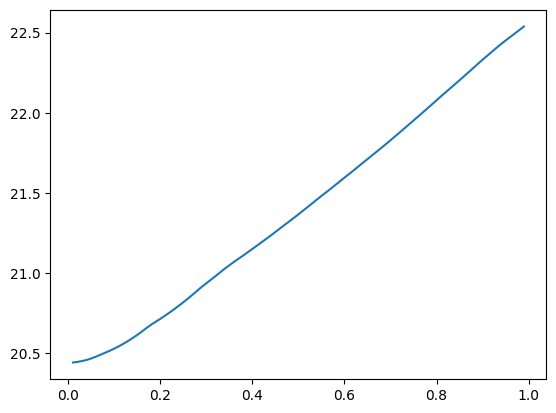

In [24]:
alpha = []
error = []
for i in range(1, 100):
    alpha.append(i/100)
    lml = Lasso(alpha = i/100)
    lml.fit(X_train, y_train)
    error.append(np.sqrt(mean_squared_error(y_train, lml.predict(X_train))))
plt.plot(alpha, error)

In [25]:
err = tuple(zip(alpha, error))
df_err = pd.DataFrame(err, columns = ['alpha', 'error'])
df_err[df_err.error == min(df_err.error)]

,alpha,error
0,0.01,20.441969


In [26]:
tuned_lm_l = Lasso(alpha=0.01)
tuned_lm_l.fit(X_train, y_train)

Lasso(alpha=0.01)

In [27]:
# Random forest
from sklearn.ensemble import RandomForestRegressor

In [28]:
rf = RandomForestRegressor()

In [29]:
from sklearn.model_selection import cross_val_score

In [30]:
np.mean(cross_val_score(rf, X_train, y_train, scoring='neg_mean_absolute_error', cv=3))

-15.034583055598285

In [31]:
# tune models using Gridsearchcv
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators' : range(10, 100, 10),
    'criterion' : ('squared_error', 'absolute_error'),
    'max_features' : (1.0, 'sqrt', 'log2')
}

In [32]:
gs = GridSearchCV(rf, params, scoring='neg_mean_absolute_error')

In [33]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'criterion': ('squared_error', 'absolute_error'),
                         'max_features': (1.0, 'sqrt', 'log2'),
                         'n_estimators': range(10, 100, 10)},
             scoring='neg_mean_absolute_error')

In [34]:
gs.best_score_

-13.362532936903573

In [35]:
gs.best_params_

{'criterion': 'squared_error', 'max_features': 1.0, 'n_estimators': 40}

In [36]:
gs.best_estimator_

RandomForestRegressor(n_estimators=40)

In [37]:
# test ensembles
tpred_lm_l = tuned_lm_l.predict(X_test)
tpred_rf = gs.best_estimator_.predict(X_test)

In [38]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_test, tpred_lm_l))
print(mean_absolute_error(y_test, tpred_rf))

18.775589699331526
11.415687919463087


In [39]:
mean_absolute_error(y_test, (tpred_lm_l + tpred_rf)/2)

14.159545030050786

In [40]:
import pickle
pickl = {'model' : gs.best_estimator_}
pickle.dump(pickl, open('model_file' + '.p', 'wb'))

In [41]:
file_name = 'model_file.p'
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']

In [42]:
model.predict(X_test[1,:].reshape(1, -1))

array([51.175])